# Chapter 14 Reward Shaping

## Example: A Simple Example with Sparse Rewards

In this notebook, we will run the Q-learning algorithms with reward shaping and without reward shaping on a simple example with sparse rewards.

### Problem Desciption

Let us consider a simple example as shown in the following figure.
The environment includes 101 states, states 0 to 99 and a “goal” state. 
The agent can moves between state $i$ and $i + 1$ for $i = 0,\ldots,98$
and an episode ends when the agent reaches the goal state. 
The agent only receives a reward of 100 when reaching the goal state, and receives no reward in any other state. Assume the agent starts in state $0$.
&nbsp;
&nbsp;

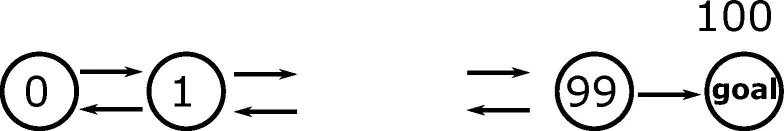

&nbsp;
&nbsp;

### Formulation

This problem can be formulated into an infinite-horizon discounted DP problem as follows:

- State $x$: $x\in\{0,1,\ldots,99,100\}$, where we use $x=100$ to denote the ``goal'' state.
    
- Action $a$: move left or right, $a\in\{-1,1\}$, where $-1$ denotes moving to the left and $1$ denotes moving to the right. Note that when the state $x=0$, the agent cannot move to the left, so the only valid action is $a=1$.
    
- Transition:
    The transition is deterministic. 
    Let $x_k$ and $a_k$ denote the state and the action at step $k$, respectively. Then the next state $x_{k+1}$ is

    $x_{k+1}=x_{k} + a_{k}$ if $0\le x_k \le 99$

    $x_{k+1}=100$ if $x_k=100$

- Reward: $r(x,a)$: 

    \begin{align*}
        r(x,a)=\begin{cases}
            100 & \mbox{if $x=99$ and $a=1$}\\
            0 & \mbox{otherwise},
        \end{cases}
    \end{align*}

- Goal: maximize the expected discounted total reward:

    \begin{align*}
        \mathbb{E}\left[\sum_{k=0}^{\infty}\alpha^k r(x_k,a_k)\right].
    \end{align*}

    We consider the discount factor $\alpha=0.99$.


In [1]:
# Import packages. Run this cell.

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Codes

### Q-learning without reward shaping

In this part, we will run Q-learing algorithm without reward shaping. We use epsilon-greedy for exploration.

The python class `QLearningAgent` implements the Q-learning algorithm.

The function `select_action` in the class will be called each step and returns an action, i.e., moving to the left or to the right.
- The input `state` is the current state.
- The output `action` is the current action, moving to the left (-1) or to the right (1).

The function `train` in the class will be called each step after the agent moves, receives a reward (if there is any), and observes the next state. It is used for the update of the Q table.
- The input `cur_state` is the current state.
- The input `cur_action` is the current action.
- The input `reward` is the reward received.
- The input `next_state` is the next state observed.

In [2]:
class QLearningAgent:

    def __init__(self, alpha, seed=None):
        self.alpha = alpha
        # The following are recommended hyper-parameters.
        # Learning rate can be set to 1000/(t+1000), where t is the number of steps that the agent has been trained.
        # Minimum learning rate: 0.001
        # Epsilon for exploration can be set to 1000/(t+1000)
        self.trained_steps = 0
        self.q_table = np.zeros((100, 2))  # The Q table.
        self.learning_rate = 1000 / (self.trained_steps + 1000)
        self.min_learning_rate = 0.001
        self.epsilon = 1000 / (self.trained_steps + 1000) # For the epsilon-greedy exploration. 
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)
        
        
    def select_action(self, state):
        """
        This function returns an action.
        Args:
            state: the state in the current step
        Returns:
            action: -1 means moving to the left; 1 means  moving to the right
        """
        # We use epsilon-greedy for exploration. 
        # With probability self.epsilon, choose an action uniformly at random; 
        # Otherwise, choose a greedy action based on self.q_table.
        if state == 0:
            return 1
        if self.rng.random() < self.epsilon:
            action = int(2 * self.rng.choice(2) - 1)
        else:
            if self.q_table[state, 0] > self.q_table[state, 1]:
                action = -1
            elif self.q_table[state, 0] < self.q_table[state, 1]:
                action = 1
            else:
                action = int(2 * self.rng.choice(2) - 1)

        return action
    
    def train(self, cur_state, cur_action, reward, next_state):
        """
        This function is used for the update of the Q table
        Args:
            - cur_state: the current state
            - cur_action: the current action
            - reward: the reward received
            - next_state: the next state observed
        """
        cur_action = int((cur_action + 1) / 2)
        if next_state != 100:
            self.q_table[cur_state, cur_action] = (1 - self.learning_rate) * self.q_table[cur_state, cur_action] + self.learning_rate * (reward + self.alpha * np.max(self.q_table[next_state, :]))
        else:
            self.q_table[cur_state, cur_action] = (1 - self.learning_rate) * self.q_table[cur_state, cur_action] + self.learning_rate * reward
        
        # Update epsilon and learning rate
        self.trained_steps += 1
        self.learning_rate = 1000 / (self.trained_steps + 1000)
        if self.learning_rate < self.min_learning_rate:
            self.learning_rate = self.min_learning_rate
        self.epsilon = 1000 / (self.trained_steps + 1000)

The following is the code for the numerical experiment. 
We limit the length of one episode to be at most 10000 steps.

We record the number of steps taken to reach the goal state for each episode.

We run the experiment for 10 times.

In [3]:
# Problem parameters
rng = np.random.default_rng(seed=0)
alpha = 0.99
num_total_steps = 10000
num_epsisodes = 200
num_runs = 10

# Learning using Q-learning
recorded_steps = 10 * num_total_steps * np.ones((num_runs, num_epsisodes))
for r in range(num_runs):
    agent = QLearningAgent(alpha)
    for episode in range(num_epsisodes):
        state = 0
        for step in range(num_total_steps):
            action = agent.select_action(state)
            if state <= 98:
                reward = 0.0
                next_state = state + action
            elif state == 99:
                next_state = state + action
                if next_state == 100:
                    reward = 100.0
                else:
                    reward = 0.0
            else:
              print("Wrong state encounted!")
            agent.train(state, action, reward, next_state)
            state = next_state
            if next_state == 100:
                recorded_steps[r, episode] = step + 1
                break


### Q-learning with reward shaping

In this part, we will run Q-learing algorithm with reward shaping. We use epsilon-greedy for exploration.

We use a potential-based shaping function, as shown in the following figure.

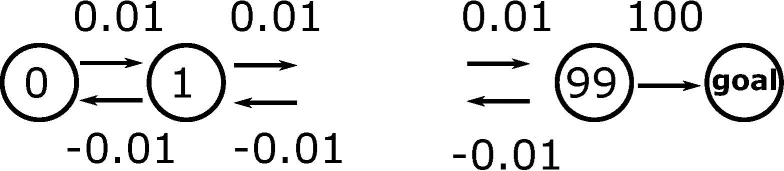

The python class `QLearningAgentRewardShaping` implements this algorithm.

The function `select_action` in the class will be called each step and returns an action, i.e., moving to the left or to the right.
- The input `state` is the current state.
- The output `action` is the current action, moving to the left (-1) or to the right (1).

The function `train` in the class will be called each step after the agent moves, receives a reward (if there is any), and observes the next state. It is used for the update of the Q table.
- The input `cur_state` is the current state.
- The input `cur_action` is the current action.
- The input `reward` is the actual reward received.
- The input `next_state` is the next state observed.

In [4]:
class QLearningAgentRewardShaping:

    def __init__(self, alpha, seed=None):
        self.alpha = alpha
        # The following are recommended hyper-parameters.
        # Learning rate can be set to 1000/(t+1000), where t is the number of steps that the agent has been trained.
        # Minimum learning rate: 0.001
        # Epsilon for exploration can be set to 1000/(t+1000)
        self.trained_steps = 0
        self.q_table = np.zeros((100, 2))  # The Q table.
        self.learning_rate = 1000 / (self.trained_steps + 1000)
        self.min_learning_rate = 0.001
        self.epsilon = 1000 / (self.trained_steps + 1000) # For the epsilon-greedy exploration. 
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)
        
        
    def select_action(self, state):
        """
        This function returns an action.
        Args:
            state: the state in the current step
        Returns:
            action: -1 means moving to the left; 1 means  moving to the right
        """
        # We use epsilon-greedy for exploration. 
        # With probability self.epsilon, choose an action uniformly at random; 
        # Otherwise, choose a greedy action based on self.q_table.
        if state == 0:
            return 1
        if self.rng.random() < self.epsilon:
            action = int(2 * self.rng.choice(2) - 1)
        else:
            if self.q_table[state, 0] > self.q_table[state, 1]:
                action = -1
            elif self.q_table[state, 0] < self.q_table[state, 1]:
                action = 1
            else:
                action = int(2 * self.rng.choice(2) - 1)

        return action
    
    def train(self, cur_state, cur_action, reward, next_state):
        """
        This function is used for the update of the Q table
        Args:
            - cur_state: the current state
            - cur_action: the current action
            - reward: the actual reward received
            - next_state: the next state observed
        """
        cur_action = int((cur_action + 1) / 2)

        # Reward Shaping
        if cur_state <= 98:
            shaped_reward = (next_state - cur_state) / 100
        elif reward == 100.0:
            shaped_reward = reward
        else:
            shaped_reward = (next_state - cur_state) / 100

        if next_state != 100:
            self.q_table[cur_state, cur_action] = (1 - self.learning_rate) * self.q_table[cur_state, cur_action] + self.learning_rate * (shaped_reward + self.alpha * np.max(self.q_table[next_state, :]))
        else:
            self.q_table[cur_state, cur_action] = (1 - self.learning_rate) * self.q_table[cur_state, cur_action] + self.learning_rate * shaped_reward
        
        # Update epsilon and learning rate
        self.trained_steps += 1
        self.learning_rate = 1000 / (self.trained_steps + 1000)
        if self.learning_rate < self.min_learning_rate:
            self.learning_rate = self.min_learning_rate
        self.epsilon = 1000 / (self.trained_steps + 1000)



The following is the code for the numerical experiment. We limit the length of one episode to be at most 10000 steps.

We record the number of steps taken to reach the goal state for each episode.

We run the experiment for 10 times.

In [5]:
# Problem parameters
rng = np.random.default_rng(seed=0)
alpha = 0.99
num_total_steps = 10000
num_epsisodes = 200
num_runs = 10

# Learning using Q-learning
recorded_steps_2 = 10 * num_total_steps * np.ones((num_runs, num_epsisodes))
for r in range(num_runs):
    agent = QLearningAgentRewardShaping(alpha)
    for episode in range(num_epsisodes):
        state = 0
        for step in range(num_total_steps):
            action = agent.select_action(state)
            if state <= 98:
                reward = 0.0
                next_state = state + action
            elif state == 99:
                next_state = state + action
                if next_state == 100:
                    reward = 100.0
                else:
                    reward = 0.0
            else:
              print("Wrong state encounted!")
            agent.train(state, action, reward, next_state)
            state = next_state
            if next_state == 100:
                recorded_steps_2[r, episode] = step + 1
                break

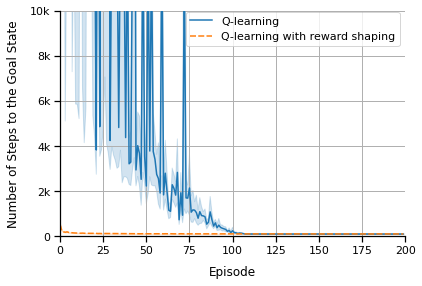

In [11]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
recorded_steps_ = np.concatenate((np.tile(np.arange(num_epsisodes).reshape((-1, 1)), (num_runs, 1)),
                                  recorded_steps.reshape((-1, 1))), axis=1)
recorded_steps_2_ = np.concatenate((np.tile(np.arange(num_epsisodes).reshape((-1, 1)), (num_runs, 1)),
                                    recorded_steps_2.reshape((-1, 1))), axis=1)

pd_data_1 = pd.DataFrame(recorded_steps_, columns=["Episode", "Number of Steps to the Goal State"])
pd_data_1["Algorithm"] = "Q-learning"
pd_data_2 = pd.DataFrame(recorded_steps_2_, columns=["Episode", "Number of Steps to the Goal State"])
pd_data_2["Algorithm"] = "Q-learning with reward shaping"

pd_data = pd.concat([pd_data_1, pd_data_2], axis=0, ignore_index=True)

with sns.plotting_context("notebook"):
    fig = sns.relplot(x="Episode", y="Number of Steps to the Goal State", markers=False, data=pd_data, kind='line',
                      hue="Algorithm", style="Algorithm",
                      height=4,
                      aspect=1.6
                      )
    fig.set_axis_labels('Episode', 'Number of Steps to the Goal State', labelpad=10)
    sns.move_legend(fig, loc="upper left", bbox_to_anchor=(0.34, 0.97), title=None, frameon=True)
    fig.set(ylim=(0, 10001))
    plt.yticks([0, 2000, 4000, 6000, 8000, 10000],
               ['0', '2k', '4k', '6k', '8k', '10k'])
    fig.set(xlim=(0, num_epsisodes))
    plt.grid()
    fig.savefig("reward_shaping_simu.pdf")
    plt.show()
